# Semestrálne zadanie 
#### Sebastián Hreško, Simona Chovancová

##### Nainštalujeme a naimportujeme si potrebné knižnice

In [1]:
#instalacia a importovanie potrebnych kniznic
!pip install findspark
!pip install pyspark
!pip install matplotlib

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, dayofweek, lit, lower, month, to_date, upper, mean, when, col, sum, split, regexp_replace, trim
!pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler


In [2]:
spark = SparkSession.builder \
    .appName("tsvd_zadanie") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/30 18:32:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### V nasledujúcej časti si načítame súbory údajov

In [3]:
#Načítanie datesetu
weather_df = spark.read.csv("airport_weather_2019.csv", header=True)
weather_df.first()

24/04/30 17:50:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(STATION='USW00013874', NAME='ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US', DATE='1/1/2019', AWND='4.7', PGTM=None, PRCP='0.14', SNOW='0.0', SNWD='0.0', TAVG='64.0', TMAX='66.0', TMIN='57.0', WDF2='310.0', WDF5='310.0', WSF2='15.0', WSF5='19.0', WT01='1.0', WT02=None, WT03=None, WT04=None, WT05=None, WT06=None, WT07=None, WT08=None, WT09=None, WESD=None, WT10=None, PSUN=None, TSUN=None, SN32=None, SX32=None, TOBS=None, WT11=None)

In [4]:
#Počet riadkov datasetu airport_weather_2019.csv
weather_df.count()

38675

In [5]:
#Načítanie druhého datasetu full_data_flightdelay.csv
flight_delay_df = spark.read.csv("full_data_flightdelay.csv", header=True)
flight_delay_df.first()

24/04/30 17:50:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
 Schema: _c0, MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
Expected: _c0 but found: 
CSV file: file:///Users/A117792292/Documents/School/sparkzadanie/full_data_flightdelay.csv


Row(_c0='0', MONTH='1', DAY_OF_WEEK='7', DEP_DEL15='0', DEP_TIME_BLK='0800-0859', DISTANCE_GROUP='2.0', SEGMENT_NUMBER='1', CONCURRENT_FLIGHTS='25', NUMBER_OF_SEATS='143', CARRIER_NAME='Southwest Airlines Co.', AIRPORT_FLIGHTS_MONTH='13056', AIRLINE_FLIGHTS_MONTH='107363', AIRLINE_AIRPORT_FLIGHTS_MONTH='5873.0', AVG_MONTHLY_PASS_AIRPORT='1903352', AVG_MONTHLY_PASS_AIRLINE='13382999', FLT_ATTENDANTS_PER_PASS='6.178236301460919e-05', GROUND_SERV_PER_PASS='9.88941230999822e-05', PLANE_AGE='8', DEPARTING_AIRPORT='McCarran International', LATITUDE='36.08', LONGITUDE='-115.152', PREVIOUS_AIRPORT='NONE')

In [6]:
#Počet riadkov datasetu full_data_flightdelay.csv
flight_delay_df.count()

6489062

## V nasledujúcej časti sa zameriame na úravy v datasete weather
###### Transformácia nominálnych atribútov na numerické
###### Transformácia numerických atribútov na nominálne
###### Vypočítanie pomerového kritéria – informačného zisku voči cieľovému atribútu (klasifikačná úloha), pre nominálne atribúty
###### Vypočítanie štatistík pre numerické atribúty
###### Vytvorenie histogramov pre nominálne atribúty
###### Spracovanie chýbajúcich hodnôt (napr. ich nahradenie priemermi, atď.)

In [7]:
# úprava formátu dátumu v stĺpci "DATE" z lomitok na pomlcky
weather_1 = weather_df.filter(col('DATE').rlike('\/')).withColumn("DATE", to_date(col("DATE"), "M/d/yyyy"))
weather_2 = weather_df.filter(col('DATE').rlike('\-'))

weather_df = weather_1.union(weather_2)

In [8]:
weather_df.first()


Row(STATION='USW00013874', NAME='ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US', DATE='2019-01-01', AWND='4.7', PGTM=None, PRCP='0.14', SNOW='0.0', SNWD='0.0', TAVG='64.0', TMAX='66.0', TMIN='57.0', WDF2='310.0', WDF5='310.0', WSF2='15.0', WSF5='19.0', WT01='1.0', WT02=None, WT03=None, WT04=None, WT05=None, WT06=None, WT07=None, WT08=None, WT09=None, WESD=None, WT10=None, PSUN=None, TSUN=None, SN32=None, SX32=None, TOBS=None, WT11=None)

In [9]:
# vytvorenie stĺpca "MONTH" s poradovým číslom mesiaca v roku z dátumu
weather_df = weather_df.withColumn("MONTH", month("DATE"))
# vytvorenie stĺpca "DAYOFWEEK" s poradovým číslom dňa v týždni z dátumu
weather_df = weather_df.withColumn("DAY_OF_WEEK", dayofweek("DATE"))
weather_df = weather_df.withColumn("DAY_OF_WEEK", when(col("DAY_OF_WEEK") == 1, 7).otherwise(col("DAY_OF_WEEK") - 1))

In [10]:
weather_df.first()

Row(STATION='USW00013874', NAME='ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US', DATE='2019-01-01', AWND='4.7', PGTM=None, PRCP='0.14', SNOW='0.0', SNWD='0.0', TAVG='64.0', TMAX='66.0', TMIN='57.0', WDF2='310.0', WDF5='310.0', WSF2='15.0', WSF5='19.0', WT01='1.0', WT02=None, WT03=None, WT04=None, WT05=None, WT06=None, WT07=None, WT08=None, WT09=None, WESD=None, WT10=None, PSUN=None, TSUN=None, SN32=None, SX32=None, TOBS=None, WT11=None, MONTH=1, DAY_OF_WEEK=2)

In [11]:
#none hodnoty v týchto atribútoch nahradíme 0
weather_df = weather_df.na.fill({'WT01': 0, 'WT02': 0, 'WT03': 0, 'WT04': 0, 'WT05': 0, 'WT06': 0, 'WT07': 0, 'WT08': 0, 'WT09': 0, 'WT10': 0, 'WT11': 0, 'SNOW': 0})

In [12]:
weather_df.first()

Row(STATION='USW00013874', NAME='ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US', DATE='2019-01-01', AWND='4.7', PGTM=None, PRCP='0.14', SNOW='0.0', SNWD='0.0', TAVG='64.0', TMAX='66.0', TMIN='57.0', WDF2='310.0', WDF5='310.0', WSF2='15.0', WSF5='19.0', WT01='1.0', WT02='0', WT03='0', WT04='0', WT05='0', WT06='0', WT07='0', WT08='0', WT09='0', WESD=None, WT10='0', PSUN=None, TSUN=None, SN32=None, SX32=None, TOBS=None, WT11='0', MONTH=1, DAY_OF_WEEK=2)

In [13]:
#zobrazíme si početnosť null hodnôt v datasete weather
null_count_weather = weather_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in weather_df.columns])
null_count_weather.show()

+-------+----+----+----+-----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+-----+----+-----+-----------+
|STATION|NAME|DATE|AWND| PGTM|PRCP|SNOW| SNWD|TAVG|TMAX|TMIN|WDF2|WDF5|WSF2|WSF5|WT01|WT02|WT03|WT04|WT05|WT06|WT07|WT08|WT09| WESD|WT10| PSUN| TSUN| SN32| SX32| TOBS|WT11|MONTH|DAY_OF_WEEK|
+-------+----+----+----+-----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+-----+----+-----+-----------+
|      0|   0|   0| 381|34737|  26|   0|12290|9933|  20|  21| 370| 481| 370| 481|   0|   0|   0|   0|   0|   0|   0|   0|   0|38669|   0|38336|38337|38310|38310|38320|   0|    0|          0|
+-------+----+----+----+-----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+-----+-----+-----+-----+-----+----+-----+-----------+



In [14]:
#Stĺpce, ktoré majú prevažnu väčšinu svojích hodnôt nulových ostránime
weather_df = weather_df.drop('PSUN', 'TSUN', 'WESD', 'SN32', 'SX32', 'TOBS', 'PGTM')

In [15]:
weather_df.first()

Row(STATION='USW00013874', NAME='ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US', DATE='2019-01-01', AWND='4.7', PRCP='0.14', SNOW='0.0', SNWD='0.0', TAVG='64.0', TMAX='66.0', TMIN='57.0', WDF2='310.0', WDF5='310.0', WSF2='15.0', WSF5='19.0', WT01='1.0', WT02='0', WT03='0', WT04='0', WT05='0', WT06='0', WT07='0', WT08='0', WT09='0', WT10='0', WT11='0', MONTH=1, DAY_OF_WEEK=2)

In [16]:
#opäť si zobrazíme početnosť null hodnôt v datasete
null_count_weather = weather_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in weather_df.columns])
null_count_weather.show()

+-------+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----------+
|STATION|NAME|DATE|AWND|PRCP|SNOW| SNWD|TAVG|TMAX|TMIN|WDF2|WDF5|WSF2|WSF5|WT01|WT02|WT03|WT04|WT05|WT06|WT07|WT08|WT09|WT10|WT11|MONTH|DAY_OF_WEEK|
+-------+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----------+
|      0|   0|   0| 381|  26|   0|12290|9933|  20|  21| 370| 481| 370| 481|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|    0|          0|
+-------+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----------+



##### NAHRADENIE NULL HODNOT V STĹPCI "SNWD" PRIEMERNÝMI HODNOTAMI podľa mesiaca


In [17]:
# definujte názvy stĺpcov
groupby_column = "MONTH"
replace_column = "SNWD"

# vypočítajte priemer pre každú skupinu
mean_df = weather_df.groupBy(groupby_column).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

weather_df = weather_df.join(mean_df, on=groupby_column)

# replace NULL hodnoty hodnotou priemeru
weather_df = weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [18]:
#dropneme už nepotrebný stĺpec mean_SNWD
weather_df = weather_df.drop('mean_SNWD')

In [19]:
#zobrazíme si početnosť null hodnôt v datasete - ELIMINOVALI SME NULL HODNOTY V STĹPCI "SNWD" (12000)
null_count_weather = weather_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in weather_df.columns])
null_count_weather.show()

+-----+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+
|MONTH|STATION|NAME|DATE|AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|WDF2|WDF5|WSF2|WSF5|WT01|WT02|WT03|WT04|WT05|WT06|WT07|WT08|WT09|WT10|WT11|DAY_OF_WEEK|
+-----+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+
|    0|      0|   0|   0| 381|  26|   0|   0|9933|  20|  21| 370| 481| 370| 481|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|          0|
+-----+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+



#### V nasledujúcej časti sa zameriame na vyplnenie NULL hodnôt v prípade atribútu TAVG

In [20]:
# Vyplnenie NULL hodnôt v stĺpci "TAVG" priemernou hodnotou z "TMAX" a "TMIN"
weather_df = weather_df.withColumn("TAVG", when(col("TAVG").isNull(), (col("TMAX") + col("TMIN")) / 2).otherwise(col("TAVG")))

In [21]:
#zobrazime si pocetnost null hodnot v datasete - ELIMINOVALI SME NULL HODNOTY V STLPCE "TAVG"
null_count_weather = weather_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in weather_df.columns])
null_count_weather.show()

+-----+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+
|MONTH|STATION|NAME|DATE|AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|WDF2|WDF5|WSF2|WSF5|WT01|WT02|WT03|WT04|WT05|WT06|WT07|WT08|WT09|WT10|WT11|DAY_OF_WEEK|
+-----+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+
|    0|      0|   0|   0| 381|  26|   0|   0|  23|  20|  21| 370| 481| 370| 481|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|          0|
+-----+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+



#### Nahradenie NULL hodnôt v prípade atribútu PRCP

In [22]:
# nahradenie NULL hodnôt v stĺpci "PRCP" priemerom stĺpca
column1_mean = weather_df.select(mean("PRCP")).collect()[0][0]
print(column1_mean)
weather_df = weather_df.fillna(column1_mean, subset=["PRCP"])

0.11279153406297497


#### Nahradenie NULL hodnôt v prípade atribútu AWND


In [23]:
# nahradenie NULL hodnôt v stĺpci "AWND" priemerom stĺpca
column1_mean = weather_df.select(mean("AWND")).collect()[0][0]
print(column1_mean)
weather_df = weather_df.fillna(column1_mean, subset=["AWND"])

7.943165247819558


In [24]:
#dropneme zvysne riadky
weather_df = weather_df.na.drop(subset=["TAVG","PRCP", "TMAX", "TMIN", "AWND", "WDF5", "WSF5"])


In [25]:
#zobrazime si pocetnost null hodnot v datasete
null_count_weather = weather_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in weather_df.columns])
null_count_weather.show()
#NEMAME ZIADNE UZ NULL HODNOTY WUHUU

+-----+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+
|MONTH|STATION|NAME|DATE|AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|WDF2|WDF5|WSF2|WSF5|WT01|WT02|WT03|WT04|WT05|WT06|WT07|WT08|WT09|WT10|WT11|DAY_OF_WEEK|
+-----+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+
|    0|      0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|          0|
+-----+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----------+



In [26]:
#výsledný počet riadkov, s ktorými budeme pracovať (po nahradení a odstréneni)
weather_df.count()


38150

## V nasledujúcej časti sa zameriame na úravy v datasete flight_delay

In [27]:
#pozrieme sa koľko null hodnôt máme v datasete s letmi
null_count_flights = flight_delay_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in flight_delay_df.columns])
null_count_flights.show()

24/04/30 17:50:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
 Schema: _c0, MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
Expected: _c0 but found: 
CSV file: file:///Users/A117792292/Documents/School/sparkzadanie/full_data_flightdelay.csv


+---+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+-----------------+--------+---------+----------------+
|_c0|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|
+---+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+------------

In [28]:
# odstránime duplicitné riadky bez ohľadu na stĺpec "_c0" lebo ten je jasne, že bude unikátny
flight_delay_df = flight_delay_df.dropDuplicates(subset=[c for c in flight_delay_df.columns if c != "_c0"])

In [29]:
flight_delay_df.count()
#BOLO ICH DOST DUPLICITNYCH

6105929

#### Prevod všetkých znakov hodnôt stĺpca "DEPARTING_AIRPORT" na veľké písmená

In [30]:
# prevod všetkých znakov hodnôt stĺpca "DEPARTING_AIRPORT" na veľké písmená
flight_delay_df = flight_delay_df.withColumn("DEPARTING_AIRPORT", upper(col("DEPARTING_AIRPORT")))

In [31]:
#Pozrieme pre ake letiska a v akom pocte mame dostupne udaje o pocasi
name_counts = weather_df.groupBy('NAME').count()
name_counts.show()

+--------------------+-----+
|                NAME|count|
+--------------------+-----+
|SEATTLE TACOMA AI...|  365|
|AUSTIN BERGSTROM ...|  365|
|MINNEAPOLIS ST. P...|  361|
|PITTSBURGH ALLEGH...|  364|
|NASHVILLE INTERNA...|  362|
|SAN JOSE INTERNAT...|  360|
|HONOLULU INTERNAT...|  364|
|LAGUARDIA AIRPORT...|  364|
|MIAMI INTERNATION...|  365|
|SAN FRANCISCO INT...|  364|
|NEW ORLEANS AIRPO...|  364|
|RALEIGH AIRPORT, ...|  365|
|ST LOUIS LAMBERT ...|  364|
|KANSAS CITY INTER...|  365|
|DENVER INTERNATIO...|  365|
|MCCARRAN INTERNAT...|  365|
|TAMPA INTERNATION...|  360|
|DALLAS FAA AIRPOR...|  365|
|FORT WORTH MEACHA...|  364|
|CHARLOTTE DOUGLAS...|  365|
+--------------------+-----+
only showing top 20 rows



In [32]:
# počty letísk v datasetoch weather_df a flight_delay_df
unique_airport_names = weather_df.select('NAME').distinct().count()
unique_departing_airports = flight_delay_df.select('DEPARTING_AIRPORT').distinct().count()

print(f'Unique airport names in airport_weather: {unique_airport_names}')
print(f'Unique departing airports in full_data_flightdelay: {unique_departing_airports}')

Unique airport names in airport_weather: 105
Unique departing airports in full_data_flightdelay: 96


In [33]:
#Do suboru output.csv si uložíme mená unikátnych letísk zoradených podľa abecedy, aby sa nám lepšie porovnavalo co treba este upravit aby nazvy sedeli
distinct_airport_names = weather_df.select('NAME').distinct().rdd.flatMap(lambda x: x).collect()
distinct_departing_airports = flight_delay_df.select('DEPARTING_AIRPORT').distinct().rdd.flatMap(lambda x: x).collect()

df1 = pd.DataFrame(distinct_airport_names, columns=['Airport Names'])
df2 = pd.DataFrame(distinct_departing_airports, columns=['Departing Airports'])

df1 = df1.sort_values(by=['Airport Names'])
df2 = df2.sort_values(by=['Departing Airports'])

df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

result = pd.concat([df1, df2], axis=1)

display(result)
result.to_csv('output.csv', index=False)

,Airport Names,Departing Airports
0,"ALBANY INTERNATIONAL AIRPORT, NY US",ADAMS FIELD
1,"ALBUQUERQUE INTERNATIONAL AIRPORT, NM US",ALBANY INTERNATIONAL
2,"ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, A...",ALBUQUERQUE INTERNATIONAL SUNPORT
3,"ASHEVILLE AIRPORT, NC US",ANCHORAGE INTERNATIONAL
4,"ASPEN PITKIN CO AIRPORT SARDY FIELD, CO US",ATLANTA MUNICIPAL
...,...,...
100,"TRAVERSE CITY CHERRY CAPITAL AIRPORT, MI US",NaN
101,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",NaN
102,"WEST PALM BEACH INTERNATIONAL AIRPORT, FL US",NaN
103,"WICHITA COLONEL JAMES JABARA AIRPORT, KS US",NaN


In [34]:
#porovname kolko letisk sa zhoduje v jednom aj druhom datasete
distinct_airport_names = set(weather_df.select('NAME').distinct().rdd.flatMap(lambda x: x).collect())
distinct_departing_airports = set(flight_delay_df.select('DEPARTING_AIRPORT').distinct().rdd.flatMap(lambda x: x).collect())

common_airports = distinct_airport_names.intersection(distinct_departing_airports)

num_common_airports = len(common_airports)

print(f'Number of departing airports contained in airport names: {num_common_airports}')

Number of departing airports contained in airport names: 0


In [35]:
#odstranime to co je za ciarkou(zbytocne)
weather_df = weather_df.withColumn('NAME', split(col('NAME'), ',').getItem(0))
weather_df.first()

Row(MONTH=1, STATION='USW00013874', NAME='ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT', DATE='2019-01-01', AWND='4.7', PRCP='0.14', SNOW='0.0', SNWD='0.0', TAVG='64.0', TMAX='66.0', TMIN='57.0', WDF2='310.0', WDF5='310.0', WSF2='15.0', WSF5='19.0', WT01='1.0', WT02='0', WT03='0', WT04='0', WT05='0', WT06='0', WT07='0', WT08='0', WT09='0', WT10='0', WT11='0', DAY_OF_WEEK=2)

In [36]:
#znova pozrieme kolko sa ich rovna v datasetoch
distinct_airport_names = set(weather_df.select('NAME').distinct().rdd.flatMap(lambda x: x).collect())
distinct_departing_airports = set(flight_delay_df.select('DEPARTING_AIRPORT').distinct().rdd.flatMap(lambda x: x).collect())

common_airports = distinct_airport_names.intersection(distinct_departing_airports)

num_common_airports = len(common_airports)

print(f'Number of departing airports contained in airport names: {num_common_airports}')

Number of departing airports contained in airport names: 2


In [37]:
# Nahradime 'AIRPORT' pradznym retazcom v stlpci 'NAME'
weather_df = weather_df.withColumn('NAME', regexp_replace(col('NAME'), ' AIRPORT', ''))

weather_df.first()

Row(MONTH=1, STATION='USW00013874', NAME='ATLANTA HARTSFIELD JACKSON INTERNATIONAL', DATE='2019-01-01', AWND='4.7', PRCP='0.14', SNOW='0.0', SNWD='0.0', TAVG='64.0', TMAX='66.0', TMIN='57.0', WDF2='310.0', WDF5='310.0', WSF2='15.0', WSF5='19.0', WT01='1.0', WT02='0', WT03='0', WT04='0', WT05='0', WT06='0', WT07='0', WT08='0', WT09='0', WT10='0', WT11='0', DAY_OF_WEEK=2)

In [38]:
#odstranime slovicka ako AIRPORT A SUNPORT
weather_df = weather_df.withColumn('NAME', regexp_replace(col('NAME'), ' AIRPORT', ''))
flight_delay_df = flight_delay_df.withColumn('DEPARTING_AIRPORT', regexp_replace(col('DEPARTING_AIRPORT'), ' SUNPORT', ''))


In [39]:
#znova pozrieme kolko sa ich rovna
distinct_airport_names = set(weather_df.select('NAME').distinct().rdd.flatMap(lambda x: x).collect())
distinct_departing_airports = set(flight_delay_df.select('DEPARTING_AIRPORT').distinct().rdd.flatMap(lambda x: x).collect())

common_airports = distinct_airport_names.intersection(distinct_departing_airports)

num_common_airports = len(common_airports)

print(f'Number of departing airports contained in airport names: {num_common_airports}')

Number of departing airports contained in airport names: 28


In [40]:
#tieto sa zatial zhoduju
common_airports_list = list(common_airports)

sorted_common_airports = sorted(common_airports_list)
print(sorted_common_airports)

['ALBANY INTERNATIONAL', 'ALBUQUERQUE INTERNATIONAL', 'BOISE AIR TERMINAL', 'EL PASO INTERNATIONAL', 'HONOLULU INTERNATIONAL', 'HOUSTON INTERCONTINENTAL', 'JACKSONVILLE INTERNATIONAL', 'KANSAS CITY INTERNATIONAL', 'LAGUARDIA', 'LOS ANGELES INTERNATIONAL', 'MCCARRAN INTERNATIONAL', 'MEMPHIS INTERNATIONAL', 'MIAMI INTERNATIONAL', 'NASHVILLE INTERNATIONAL', 'NEWARK LIBERTY INTERNATIONAL', 'NORFOLK INTERNATIONAL', 'ORLANDO INTERNATIONAL', 'PHILADELPHIA INTERNATIONAL', 'PORTLAND INTERNATIONAL', 'RICHMOND INTERNATIONAL', 'SALT LAKE CITY INTERNATIONAL', 'SAN ANTONIO INTERNATIONAL', 'SAN FRANCISCO INTERNATIONAL', 'SAN JOSE INTERNATIONAL', 'SPOKANE INTERNATIONAL', 'SYRACUSE HANCOCK INTERNATIONAL', 'TAMPA INTERNATIONAL', 'WASHINGTON DULLES INTERNATIONAL']


In [41]:
#odstranim pomlcky
flight_delay_df = flight_delay_df.withColumn('DEPARTING_AIRPORT', regexp_replace(col('DEPARTING_AIRPORT'), '-', ' '))

In [42]:
#odstranim nadbytocne medzery
flight_delay_df = flight_delay_df.withColumn('DEPARTING_AIRPORT', trim(col('DEPARTING_AIRPORT')))

flight_delay_df = flight_delay_df.withColumn('DEPARTING_AIRPORT', regexp_replace(col('DEPARTING_AIRPORT'), '[ \u00A0]+', ' '))

weather_df = weather_df.withColumn('NAME', trim(col('NAME')))

weather_df = weather_df.withColumn('NAME', regexp_replace(col('NAME'), '[ \u00A0]+', ' '))

In [43]:
#naposledy sa pozrieme kolko sa nam ich zhoduje
distinct_airport_names = set(weather_df.select('NAME').distinct().rdd.flatMap(lambda x: x).collect())
distinct_departing_airports = set(flight_delay_df.select('DEPARTING_AIRPORT').distinct().rdd.flatMap(lambda x: x).collect())

common_airports = distinct_airport_names.intersection(distinct_departing_airports)

num_common_airports = len(common_airports)

print(f'Number of departing airports contained in airport names: {num_common_airports}')

Number of departing airports contained in airport names: 30


In [44]:
# vyfiltrujeme len udaje z tych letisk, ku ktorym mame aj data o pocasi
filtered_flight_delay_df = flight_delay_df.filter(col('DEPARTING_AIRPORT').isin(common_airports))
filtered_flight_delay_df.count()

2135349

In [45]:
#zosortujeme podla mena letiska
sorted_filtered_flight_delay_df = filtered_flight_delay_df.orderBy("DEPARTING_AIRPORT")
sorted_filtered_flight_delay_df.take(5)


24/04/30 17:52:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
 Schema: _c0, MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
Expected: _c0 but found: 
CSV file: file:///Users/A117792292/Documents/School/sparkzadanie/full_data_flightdelay.csv


[Row(_c0='2436840', MONTH='5', DAY_OF_WEEK='1', DEP_DEL15='0', DEP_TIME_BLK='0600-0659', DISTANCE_GROUP='4.0', SEGMENT_NUMBER='1', CONCURRENT_FLIGHTS='6', NUMBER_OF_SEATS='76', CARRIER_NAME='SkyWest Airlines Inc.', AIRPORT_FLIGHTS_MONTH='1110', AIRLINE_FLIGHTS_MONTH='70878', AIRLINE_AIRPORT_FLIGHTS_MONTH='224.0', AVG_MONTHLY_PASS_AIRPORT='124691', AVG_MONTHLY_PASS_AIRLINE='3472966', FLT_ATTENDANTS_PER_PASS='3.419267401443636e-05', GROUND_SERV_PER_PASS='9.900278805864172e-05', PLANE_AGE='0', DEPARTING_AIRPORT='ALBANY INTERNATIONAL', LATITUDE='42.746', LONGITUDE='-73.805', PREVIOUS_AIRPORT='NONE'),
 Row(_c0='2446598', MONTH='5', DAY_OF_WEEK='2', DEP_DEL15='0', DEP_TIME_BLK='0600-0659', DISTANCE_GROUP='4.0', SEGMENT_NUMBER='1', CONCURRENT_FLIGHTS='6', NUMBER_OF_SEATS='76', CARRIER_NAME='SkyWest Airlines Inc.', AIRPORT_FLIGHTS_MONTH='1110', AIRLINE_FLIGHTS_MONTH='70878', AIRLINE_AIRPORT_FLIGHTS_MONTH='224.0', AVG_MONTHLY_PASS_AIRPORT='124691', AVG_MONTHLY_PASS_AIRLINE='3472966', FLT_ATTEND

In [46]:
#pocet riadkov z datasetu s pocasim ktore nam ostanu po filtrovani
filtered_weather_df = weather_df.filter(col('NAME').isin(common_airports))
filtered_weather_df.count()

10908

In [47]:
#zosortujeme podla mena letiska
sorted_filtered_weather_df = filtered_weather_df.orderBy("NAME")
sorted_filtered_weather_df.take(5)

[Row(MONTH=1, STATION='USW00014735', NAME='ALBANY INTERNATIONAL', DATE='2019-01-01', AWND='15.21', PRCP='0.1', SNOW='0.0', SNWD='0.0', TAVG='42.0', TMAX='53.0', TMIN='27.0', WDF2='280.0', WDF5='280.0', WSF2='36.0', WSF5='55.0', WT01='1.0', WT02='0', WT03='0', WT04='0', WT05='0', WT06='0', WT07='0', WT08='0', WT09='0', WT10='0', WT11='0', DAY_OF_WEEK=2),
 Row(MONTH=1, STATION='USW00014735', NAME='ALBANY INTERNATIONAL', DATE='2019-01-05', AWND='4.7', PRCP='0.42', SNOW='0.0', SNWD='0.0', TAVG='36.0', TMAX='40.0', TMIN='29.0', WDF2='300.0', WDF5='280.0', WSF2='18.1', WSF5='23.0', WT01='1.0', WT02='0', WT03='0', WT04='0', WT05='0', WT06='1.0', WT07='0', WT08='0', WT09='0', WT10='0', WT11='0', DAY_OF_WEEK=6),
 Row(MONTH=1, STATION='USW00014735', NAME='ALBANY INTERNATIONAL', DATE='2019-01-02', AWND='3.8', PRCP='0.0', SNOW='0.0', SNWD='0.0', TAVG='28.0', TMAX='34.0', TMIN='20.0', WDF2='170.0', WDF5='160.0', WSF2='18.1', WSF5='23.9', WT01='0', WT02='0', WT03='0', WT04='0', WT05='0', WT06='0', W

In [48]:
#zobrazime si pocetnosti zaznamov pre dane letiska v datasete o pocasi 
weather_counts = sorted_filtered_weather_df.groupBy('NAME').count()
weather_counts.show()

+--------------------+-----+
|                NAME|count|
+--------------------+-----+
|CLEVELAND HOPKINS...|  364|
|HOUSTON INTERCONT...|  364|
|           LAGUARDIA|  364|
| TAMPA INTERNATIONAL|  360|
|HONOLULU INTERNAT...|  364|
|MCCARRAN INTERNAT...|  365|
|SAN ANTONIO INTER...|  364|
|SALT LAKE CITY IN...|  365|
|AUSTIN BERGSTROM ...|  365|
|PORTLAND INTERNAT...|  365|
| MIAMI INTERNATIONAL|  365|
|KANSAS CITY INTER...|  365|
|LOS ANGELES INTER...|  361|
|SAN FRANCISCO INT...|  364|
|PHILADELPHIA INTE...|  365|
|JACKSONVILLE INTE...|  363|
|SAN JOSE INTERNAT...|  360|
|NASHVILLE INTERNA...|  362|
|NEWARK LIBERTY IN...|  364|
|WASHINGTON DULLES...|  365|
+--------------------+-----+
only showing top 20 rows



In [49]:
#zobrazime si pocetnosti zaznamov pre dane letiska v datasete s letmi
common_airports_list = list(common_airports)

filtered_df = filtered_flight_delay_df.filter(filtered_flight_delay_df.DEPARTING_AIRPORT.isin(common_airports_list))

airport_counts = filtered_df.groupBy('DEPARTING_AIRPORT').count()

airport_counts.show()

+--------------------+------+
|   DEPARTING_AIRPORT| count|
+--------------------+------+
|SYRACUSE HANCOCK ...| 10080|
|CLEVELAND HOPKINS...| 44217|
|HOUSTON INTERCONT...|168450|
|SPOKANE INTERNATI...|  3117|
|           LAGUARDIA|154678|
| TAMPA INTERNATIONAL| 71333|
|HONOLULU INTERNAT...| 40067|
|  BOISE AIR TERMINAL| 15976|
|MCCARRAN INTERNAT...|154495|
|NORFOLK INTERNATI...| 21129|
|SAN ANTONIO INTER...| 37123|
|SALT LAKE CITY IN...|106374|
|RICHMOND INTERNAT...| 21188|
|ALBUQUERQUE INTER...| 21562|
|MEMPHIS INTERNATI...| 22391|
|AUSTIN BERGSTROM ...| 61877|
|PORTLAND INTERNAT...| 58332|
| MIAMI INTERNATIONAL| 82159|
|KANSAS CITY INTER...| 50341|
|LOS ANGELES INTER...|207589|
+--------------------+------+
only showing top 20 rows



In [50]:
#znova sa pozrieme na null hodnoty v novom datasete s letmi
null_count_flights = sorted_filtered_flight_delay_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in flight_delay_df.columns])
null_count_flights.show()

24/04/30 17:53:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
 Schema: _c0, MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
Expected: _c0 but found: 
CSV file: file:///Users/A117792292/Documents/School/sparkzadanie/full_data_flightdelay.csv


+---+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+-----------------+--------+---------+----------------+
|_c0|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|
+---+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+------------

In [51]:
#dropneme null hodnoty - riadky
sorted_filtered_flight_delay_df = sorted_filtered_flight_delay_df.na.drop(subset=["DISTANCE_GROUP", "FLT_ATTENDANTS_PER_PASS", "AIRLINE_AIRPORT_FLIGHTS_MONTH"])

In [52]:
#overime ci uz mame vsetky null hodnoty odstranene
null_count_flights = sorted_filtered_flight_delay_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in sorted_filtered_flight_delay_df.columns])
null_count_flights.show()

24/04/30 17:54:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
 Schema: _c0, MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
Expected: _c0 but found: 
CSV file: file:///Users/A117792292/Documents/School/sparkzadanie/full_data_flightdelay.csv


+---+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+-----------------+--------+---------+----------------+
|_c0|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|
+---+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+------------

In [53]:
# pocet kolko riadkov nam zostalo po cisteni datasetu
row_count = sorted_filtered_flight_delay_df.count()

print(f"The DataFrame has {row_count} rows.")

The DataFrame has 2067797 rows.


In [54]:
#IDEME PRIEMEROVAT VSETKO PODLA MESIACA A DNIA V TYZDNI LEBO MAME 4 UDAJE PRE KAZDY DEN V MESIACI A CHCEME MAT LEN JEDEN aby sme to mohli joinut
#cize vytvorime z kazdeho numerickeho atributu priemer a ten zapiseme do noveho atributu s nazvom mean_ + nazov atributu cize 4 riadky s rovnakym month a day of week budu mat rovnake hodnoty v mean_ + nazov atributu
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "TAVG"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)


sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [55]:

groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "SNWD"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)


sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [56]:
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "AWND"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [57]:
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "TMAX"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [58]:
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "TMIN"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [59]:
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "WDF2"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [60]:
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "WDF5"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [61]:
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "WSF5"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [62]:
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "WSF2"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)


In [63]:
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "SNOW"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)


In [64]:
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]
replace_column = "PRCP"

# vypočítajte priemer pre každú skupinu
mean_df = sorted_filtered_weather_df.groupBy(groupby_columns).agg(
  mean(replace_column).alias('mean_' + replace_column)
)

sorted_filtered_weather_df = sorted_filtered_weather_df.join(mean_df, on=groupby_columns)

sorted_filtered_weather_df = sorted_filtered_weather_df.withColumn(
  replace_column,
  when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
)

In [65]:
sorted_filtered_weather_df.take(5)

[Row(MONTH=1, DAY_OF_WEEK=2, NAME='AUSTIN BERGSTROM INTERNATIONAL', STATION='USW00013904', DATE='2019-01-01', AWND='12.3', PRCP='0.0', SNOW='0.0', SNWD='0.0', TAVG='43.0', TMAX='46.0', TMIN='33.0', WDF2='20.0', WDF5='10.0', WSF2='23.0', WSF5='25.1', WT01='1.0', WT02='1.0', WT03='0', WT04='0', WT05='0', WT06='0', WT07='0', WT08='0', WT09='0', WT10='0', WT11='0', mean_TAVG=53.2, mean_SNWD=0.0, mean_AWND=9.306000000000001, mean_TMAX=59.4, mean_TMIN=41.6, mean_WDF2=116.0, mean_WDF5=114.0, mean_WSF5=26.439999999999998, mean_WSF2=22.64, mean_SNOW=0.0, mean_PRCP=0.02),
 Row(MONTH=1, DAY_OF_WEEK=3, NAME='AUSTIN BERGSTROM INTERNATIONAL', STATION='USW00013904', DATE='2019-01-02', AWND='10.96', PRCP='2.16', SNOW='0.0', SNWD='0.0', TAVG='39.0', TMAX='42.0', TMIN='37.0', WDF2='360.0', WDF5='350.0', WSF2='17.0', WSF5='21.9', WT01='1.0', WT02='0', WT03='0', WT04='0', WT05='0', WT06='0', WT07='0', WT08='0', WT09='0', WT10='0', WT11='0', mean_TAVG=48.6, mean_SNWD=0.0, mean_AWND=8.634, mean_TMAX=55.0, m

In [65]:
# Zoznam atributov, ktore dropneme
columns_to_drop = ['SNWD', 'AWND','DATE', 'TAVG','TMAX', 'TMIN', 'WDF2','WDF5', 'WSF5', 'WSF2','SNOW', 'PRCP']

# Dropneme stlpce 
sorted_filtered_weather_df = sorted_filtered_weather_df.drop(*columns_to_drop)

In [66]:
sorted_filtered_flight_delay_df.write.options(header='True').csv('sorted_filtered_flight_delay_df_final.csv')

24/04/30 17:56:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
 Schema: _c0, MONTH, DAY_OF_WEEK, DEP_DEL15, DEP_TIME_BLK, DISTANCE_GROUP, SEGMENT_NUMBER, CONCURRENT_FLIGHTS, NUMBER_OF_SEATS, CARRIER_NAME, AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRPORT, AVG_MONTHLY_PASS_AIRLINE, FLT_ATTENDANTS_PER_PASS, GROUND_SERV_PER_PASS, PLANE_AGE, DEPARTING_AIRPORT, LATITUDE, LONGITUDE, PREVIOUS_AIRPORT
Expected: _c0 but found: 
CSV file: file:///Users/A117792292/Documents/School/sparkzadanie/full_data_flightdelay.csv


In [67]:
sorted_filtered_weather_df.write.options(header='True').csv('sorted_filtered_avg_weather_df_final.csv')

In [3]:
#nacitanie novych datasetov odznova - odporucam restart kernel lebo bude pc kaput
sorted_filtered_flight_delay_df = spark.read.csv('sorted_filtered_flight_delay_df_final.csv', header=True)
sorted_filtered_avg_weather_df = spark.read.csv('sorted_filtered_avg_weather_df_final.csv', header=True)

In [4]:
#este nam ostali vsetky WT-- atributy, ktore chceme zmenit na priemerne hodnoty
groupby_columns = ["MONTH","DAY_OF_WEEK","NAME"]

for i in range(1, 12):
    replace_column = "WT{:02d}".format(i)

    mean_df = sorted_filtered_avg_weather_df.groupBy(groupby_columns).agg(
      mean(replace_column).alias('mean_' + replace_column)
    )


    sorted_filtered_avg_weather_df = sorted_filtered_avg_weather_df.join(mean_df, on=groupby_columns)

    sorted_filtered_avg_weather_df = sorted_filtered_avg_weather_df.withColumn(
      replace_column,
      when(col(replace_column).isNull(), col('mean_' + replace_column)).otherwise(col(replace_column))
    )

In [5]:
#dropneme uz nepotrebne atributy
columns_to_drop = ['WT02', 'WT03', 'WT04','WT01','WT05', 'WT06', 'WT07','WT08','WT09', 'WT10', 'WT11']

sorted_filtered_avg_weather_df = sorted_filtered_avg_weather_df.drop(*columns_to_drop)

In [6]:
sorted_filtered_avg_weather_df.take(5)

24/04/30 18:35:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(MONTH='1', DAY_OF_WEEK='2', NAME='AUSTIN BERGSTROM INTERNATIONAL', STATION='USW00013904', mean_TAVG='53.2', mean_SNWD='0.0', mean_AWND='9.306000000000001', mean_TMAX='59.4', mean_TMIN='41.6', mean_WDF2='116.0', mean_WDF5='114.0', mean_WSF5='26.439999999999998', mean_WSF2='22.64', mean_SNOW='0.0', mean_PRCP='0.02', mean_WT01=0.6, mean_WT02=0.4, mean_WT03=0.0, mean_WT04=0.0, mean_WT05=0.0, mean_WT06=0.0, mean_WT07=0.0, mean_WT08=0.0, mean_WT09=0.0, mean_WT10=0.0, mean_WT11=0.0),
 Row(MONTH='1', DAY_OF_WEEK='3', NAME='AUSTIN BERGSTROM INTERNATIONAL', STATION='USW00013904', mean_TAVG='48.6', mean_SNWD='0.0', mean_AWND='8.634', mean_TMAX='55.0', mean_TMIN='38.8', mean_WDF2='210.0', mean_WDF5='204.0', mean_WSF5='22.580000000000002', mean_WSF2='17.82', mean_SNOW='0.0', mean_PRCP='0.442', mean_WT01=0.4, mean_WT02=0.0, mean_WT03=0.0, mean_WT04=0.2, mean_WT05=0.0, mean_WT06=0.0, mean_WT07=0.0, mean_WT08=0.0, mean_WT09=0.0, mean_WT10=0.0, mean_WT11=0.0),
 Row(MONTH='1', DAY_OF_WEEK='4', NAME

In [7]:
#znova zapiseme do uz finalneho finalneho datasetu s pocasim
sorted_filtered_avg_weather_df.write.options(header='True').csv('sorted_filtered_avg_weather_df_final_final.csv')

In [8]:
#nacitame si finalny finalny dataset s pocasim
sorted_filtered_avg_weather_df = spark.read.csv('sorted_filtered_avg_weather_df_final_final.csv', header=True)

In [9]:
#pre kontrolu si zobrazime zaznamy a skontrolujeme ci tieto 4 riadky maju rovnake zaznamy
fordays_atlanta = sorted_filtered_avg_weather_df.filter((col('MONTH') == 1) & (col('DAY_OF_WEEK') == 7)& (col('NAME') == 'ALBANY INTERNATIONAL'))


# Display the filtered DataFrame
fordays_atlanta.take(4)

[Row(MONTH='1', DAY_OF_WEEK='7', NAME='ALBANY INTERNATIONAL', STATION='USW00014735', mean_TAVG='22.25', mean_SNWD='3.525', mean_AWND='9.8975', mean_TMAX='32.0', mean_TMIN='10.75', mean_WDF2='202.5', mean_WDF5='205.0', mean_WSF5='30.75', mean_WSF2='23.55', mean_SNOW='2.6750000000000003', mean_PRCP='0.32', mean_WT01='0.75', mean_WT02='0.25', mean_WT03='0.0', mean_WT04='0.25', mean_WT05='0.0', mean_WT06='0.25', mean_WT07='0.0', mean_WT08='0.0', mean_WT09='0.25', mean_WT10='0.0', mean_WT11='0.0'),
 Row(MONTH='1', DAY_OF_WEEK='7', NAME='ALBANY INTERNATIONAL', STATION='USW00014735', mean_TAVG='22.25', mean_SNWD='3.525', mean_AWND='9.8975', mean_TMAX='32.0', mean_TMIN='10.75', mean_WDF2='202.5', mean_WDF5='205.0', mean_WSF5='30.75', mean_WSF2='23.55', mean_SNOW='2.6750000000000003', mean_PRCP='0.32', mean_WT01='0.75', mean_WT02='0.25', mean_WT03='0.0', mean_WT04='0.25', mean_WT05='0.0', mean_WT06='0.25', mean_WT07='0.0', mean_WT08='0.0', mean_WT09='0.25', mean_WT10='0.0', mean_WT11='0.0'),
 R

In [10]:
#tu mame pre kazdy den jeden zaznam
sorted_filtered_avg_weather_df.groupBy('NAME').count().show()


+--------------------+-----+
|                NAME|count|
+--------------------+-----+
|CLEVELAND HOPKINS...|  364|
|HOUSTON INTERCONT...|  364|
|           LAGUARDIA|  364|
| TAMPA INTERNATIONAL|  360|
|HONOLULU INTERNAT...|  364|
|MCCARRAN INTERNAT...|  365|
|SAN ANTONIO INTER...|  364|
|SALT LAKE CITY IN...|  365|
|AUSTIN BERGSTROM ...|  365|
|PORTLAND INTERNAT...|  365|
| MIAMI INTERNATIONAL|  365|
|KANSAS CITY INTER...|  365|
|LOS ANGELES INTER...|  361|
|SAN FRANCISCO INT...|  364|
|PHILADELPHIA INTE...|  365|
|JACKSONVILLE INTE...|  363|
|SAN JOSE INTERNAT...|  360|
|NASHVILLE INTERNA...|  362|
|NEWARK LIBERTY IN...|  364|
|WASHINGTON DULLES...|  365|
+--------------------+-----+
only showing top 20 rows



In [11]:
#dropneme duplikaty a mali by nam ostat uz len 1/4 zaznamov, ktoré môžeme joinut s datasetom s letmi
sorted_filtered_avg_weather_df = sorted_filtered_avg_weather_df.dropDuplicates()

In [12]:
#overenie
sorted_filtered_avg_weather_df.groupBy('NAME').count().show()


+--------------------+-----+
|                NAME|count|
+--------------------+-----+
|SYRACUSE HANCOCK ...|   84|
|CLEVELAND HOPKINS...|   84|
|HOUSTON INTERCONT...|   84|
|SPOKANE INTERNATI...|   84|
|           LAGUARDIA|   84|
| TAMPA INTERNATIONAL|   84|
|HONOLULU INTERNAT...|   84|
|  BOISE AIR TERMINAL|   84|
|MCCARRAN INTERNAT...|   84|
|NORFOLK INTERNATI...|   84|
|SAN ANTONIO INTER...|   84|
|SALT LAKE CITY IN...|   84|
|RICHMOND INTERNAT...|   84|
|ALBUQUERQUE INTER...|   84|
|MEMPHIS INTERNATI...|   84|
|AUSTIN BERGSTROM ...|   84|
|PORTLAND INTERNAT...|   84|
| MIAMI INTERNATIONAL|   84|
|KANSAS CITY INTER...|   84|
|LOS ANGELES INTER...|   84|
+--------------------+-----+
only showing top 20 rows



In [13]:
#premenujeme tieto stlpce z dovodu mergovania
sorted_filtered_avg_weather_df = sorted_filtered_avg_weather_df.withColumnRenamed('MONTH', 'MONTH_WEATHER')
sorted_filtered_avg_weather_df = sorted_filtered_avg_weather_df.withColumnRenamed('DAY_OF_WEEK', 'DAY_OF_WEEK_WEATHER')

In [14]:
# vykoname spojenie datasetov
result_df = sorted_filtered_flight_delay_df.alias('a').join(
    sorted_filtered_avg_weather_df.alias('b'),
    (col('a.DEPARTING_AIRPORT') == col('b.NAME')) &
    (col('a.MONTH') == col('b.MONTH_WEATHER')) &
    (col('a.DAY_OF_WEEK') == col('b.DAY_OF_WEEK_WEATHER'))  # specify 'a' or 'b' here
)

In [15]:
result_df.count()


2067797

In [16]:
result_df.first()


Row(_c0='5409064', MONTH='11', DAY_OF_WEEK='1', DEP_DEL15='0', DEP_TIME_BLK='1100-1159', DISTANCE_GROUP='4.0', SEGMENT_NUMBER='2', CONCURRENT_FLIGHTS='31', NUMBER_OF_SEATS='181', CARRIER_NAME='Alaska Airlines Inc.', AIRPORT_FLIGHTS_MONTH='17358', AIRLINE_FLIGHTS_MONTH='20832', AIRLINE_AIRPORT_FLIGHTS_MONTH='1558.0', AVG_MONTHLY_PASS_AIRPORT='2780593', AVG_MONTHLY_PASS_AIRLINE='2884187', FLT_ATTENDANTS_PER_PASS='3.233146156611231e-05', GROUND_SERV_PER_PASS='0.0001746014497265', PLANE_AGE='0', DEPARTING_AIRPORT='LOS ANGELES INTERNATIONAL', LATITUDE='33.942', LONGITUDE='-118.408', PREVIOUS_AIRPORT='Logan International', MONTH_WEATHER='11', DAY_OF_WEEK_WEATHER='1', NAME='LOS ANGELES INTERNATIONAL', STATION='USW00023174', mean_TAVG='66.75', mean_SNWD='0.22284840541721268', mean_AWND='6.2625', mean_TMAX='76.5', mean_TMIN='57.0', mean_WDF2='267.5', mean_WDF5='245.0', mean_WSF5='20.35', mean_WSF2='16.5', mean_SNOW='0.0', mean_PRCP='0.0', mean_WT01='0.5', mean_WT02='0.25', mean_WT03='0.0', mean

In [17]:
#dropneme duplikatne atributy
result_df = result_df.drop('NAME', 'MONTH_WEATHER', 'DAY_OF_WEEK_WEATHER','_c0')


In [18]:
#ulozime dataset pre dalsiu pracu
result_df.write.options(header='True').csv('joined_dataset_final.csv')


In [19]:
#restartujeme kernel a nacitame dataset
joined_dataset = spark.read.csv('joined_dataset_final.csv', header=True)
joined_dataset.first()


Row(MONTH='11', DAY_OF_WEEK='1', DEP_DEL15='0', DEP_TIME_BLK='1100-1159', DISTANCE_GROUP='4.0', SEGMENT_NUMBER='2', CONCURRENT_FLIGHTS='31', NUMBER_OF_SEATS='181', CARRIER_NAME='Alaska Airlines Inc.', AIRPORT_FLIGHTS_MONTH='17358', AIRLINE_FLIGHTS_MONTH='20832', AIRLINE_AIRPORT_FLIGHTS_MONTH='1558.0', AVG_MONTHLY_PASS_AIRPORT='2780593', AVG_MONTHLY_PASS_AIRLINE='2884187', FLT_ATTENDANTS_PER_PASS='3.233146156611231e-05', GROUND_SERV_PER_PASS='0.0001746014497265', PLANE_AGE='0', DEPARTING_AIRPORT='LOS ANGELES INTERNATIONAL', LATITUDE='33.942', LONGITUDE='-118.408', PREVIOUS_AIRPORT='Logan International', STATION='USW00023174', mean_TAVG='66.75', mean_SNWD='0.22284840541721268', mean_AWND='6.2625', mean_TMAX='76.5', mean_TMIN='57.0', mean_WDF2='267.5', mean_WDF5='245.0', mean_WSF5='20.35', mean_WSF2='16.5', mean_SNOW='0.0', mean_PRCP='0.0', mean_WT01='0.5', mean_WT02='0.25', mean_WT03='0.0', mean_WT04='0.0', mean_WT05='0.0', mean_WT06='0.0', mean_WT07='0.0', mean_WT08='0.25', mean_WT09='0

# MODELOVANIE A VIZUALIZÁCIA DÁT

#### V nasledujúcej časti si ešte ďalej pripravíme dáta na modelovanie

In [22]:
joined_dataset.dtypes

[('MONTH', 'string'),
 ('DAY_OF_WEEK', 'string'),
 ('DEP_DEL15', 'string'),
 ('DEP_TIME_BLK', 'string'),
 ('DISTANCE_GROUP', 'string'),
 ('SEGMENT_NUMBER', 'string'),
 ('CONCURRENT_FLIGHTS', 'string'),
 ('NUMBER_OF_SEATS', 'string'),
 ('CARRIER_NAME', 'string'),
 ('AIRPORT_FLIGHTS_MONTH', 'string'),
 ('AIRLINE_FLIGHTS_MONTH', 'string'),
 ('AIRLINE_AIRPORT_FLIGHTS_MONTH', 'string'),
 ('AVG_MONTHLY_PASS_AIRPORT', 'string'),
 ('AVG_MONTHLY_PASS_AIRLINE', 'string'),
 ('FLT_ATTENDANTS_PER_PASS', 'string'),
 ('GROUND_SERV_PER_PASS', 'string'),
 ('PLANE_AGE', 'string'),
 ('DEPARTING_AIRPORT', 'string'),
 ('LATITUDE', 'string'),
 ('LONGITUDE', 'string'),
 ('PREVIOUS_AIRPORT', 'string'),
 ('STATION', 'string'),
 ('mean_TAVG', 'string'),
 ('mean_SNWD', 'string'),
 ('mean_AWND', 'string'),
 ('mean_TMAX', 'string'),
 ('mean_TMIN', 'string'),
 ('mean_WDF2', 'string'),
 ('mean_WDF5', 'string'),
 ('mean_WSF5', 'string'),
 ('mean_WSF2', 'string'),
 ('mean_SNOW', 'string'),
 ('mean_PRCP', 'string'),
 (

In [23]:

# Konverzia datovych typov
joined_dataset = joined_dataset.withColumn('CONCURRENT_FLIGHTS', col('CONCURRENT_FLIGHTS').cast('int'))
joined_dataset = joined_dataset.withColumn('NUMBER_OF_SEATS', col('NUMBER_OF_SEATS').cast('int'))
joined_dataset = joined_dataset.withColumn('DISTANCE_GROUP', col('DISTANCE_GROUP').cast('int'))
joined_dataset = joined_dataset.withColumn('SEGMENT_NUMBER', col('SEGMENT_NUMBER').cast('int'))

joined_dataset = joined_dataset.withColumn('AIRPORT_FLIGHTS_MONTH', col('AIRPORT_FLIGHTS_MONTH').cast('int'))
joined_dataset = joined_dataset.withColumn('AIRLINE_FLIGHTS_MONTH', col('AIRLINE_FLIGHTS_MONTH').cast('int'))
joined_dataset = joined_dataset.withColumn('AIRLINE_AIRPORT_FLIGHTS_MONTH', col('AIRLINE_AIRPORT_FLIGHTS_MONTH').cast('int'))
joined_dataset = joined_dataset.withColumn('AVG_MONTHLY_PASS_AIRPORT', col('AVG_MONTHLY_PASS_AIRPORT').cast('int'))
joined_dataset = joined_dataset.withColumn('AVG_MONTHLY_PASS_AIRLINE', col('AVG_MONTHLY_PASS_AIRLINE').cast('int'))
joined_dataset = joined_dataset.withColumn('FLT_ATTENDANTS_PER_PASS', col('FLT_ATTENDANTS_PER_PASS').cast('float'))
joined_dataset = joined_dataset.withColumn('GROUND_SERV_PER_PASS', col('GROUND_SERV_PER_PASS').cast('float'))
joined_dataset = joined_dataset.withColumn('PLANE_AGE', col('PLANE_AGE').cast('float'))
joined_dataset = joined_dataset.withColumn('LATITUDE', col('LATITUDE').cast('float'))
joined_dataset = joined_dataset.withColumn('LONGITUDE', col('LONGITUDE').cast('float'))

columns_to_convert = ['mean_SNWD', 'mean_TAVG', 'mean_AWND', 'mean_TMAX', 'mean_TMIN', 'mean_WDF2', 'mean_WDF5', 'mean_WSF5', 'mean_WSF2', 'mean_SNOW', 'mean_PRCP', 'mean_WT01', 'mean_WT02', 'mean_WT03', 'mean_WT04', 'mean_WT05', 'mean_WT06', 'mean_WT07', 'mean_WT08', 'mean_WT09', 'mean_WT10', 'mean_WT11']

for column in columns_to_convert:
    joined_dataset = joined_dataset.withColumn(column, col(column).cast('float'))

print(joined_dataset.dtypes)

[('MONTH', 'string'), ('DAY_OF_WEEK', 'string'), ('DEP_DEL15', 'string'), ('DEP_TIME_BLK', 'string'), ('DISTANCE_GROUP', 'int'), ('SEGMENT_NUMBER', 'int'), ('CONCURRENT_FLIGHTS', 'int'), ('NUMBER_OF_SEATS', 'int'), ('CARRIER_NAME', 'string'), ('AIRPORT_FLIGHTS_MONTH', 'int'), ('AIRLINE_FLIGHTS_MONTH', 'int'), ('AIRLINE_AIRPORT_FLIGHTS_MONTH', 'int'), ('AVG_MONTHLY_PASS_AIRPORT', 'int'), ('AVG_MONTHLY_PASS_AIRLINE', 'int'), ('FLT_ATTENDANTS_PER_PASS', 'float'), ('GROUND_SERV_PER_PASS', 'float'), ('PLANE_AGE', 'float'), ('DEPARTING_AIRPORT', 'string'), ('LATITUDE', 'float'), ('LONGITUDE', 'float'), ('PREVIOUS_AIRPORT', 'string'), ('STATION', 'string'), ('mean_TAVG', 'float'), ('mean_SNWD', 'float'), ('mean_AWND', 'float'), ('mean_TMAX', 'float'), ('mean_TMIN', 'float'), ('mean_WDF2', 'float'), ('mean_WDF5', 'float'), ('mean_WSF5', 'float'), ('mean_WSF2', 'float'), ('mean_SNOW', 'float'), ('mean_PRCP', 'float'), ('mean_WT01', 'float'), ('mean_WT02', 'float'), ('mean_WT03', 'float'), ('mea

In [26]:
joined_dataset = joined_dataset.withColumn('DEP_DEL15', col('DEP_DEL15').cast('boolean'))

In [27]:
joined_dataset.dtypes


[('MONTH', 'string'),
 ('DAY_OF_WEEK', 'string'),
 ('DEP_DEL15', 'boolean'),
 ('DEP_TIME_BLK', 'string'),
 ('DISTANCE_GROUP', 'int'),
 ('SEGMENT_NUMBER', 'int'),
 ('CONCURRENT_FLIGHTS', 'int'),
 ('NUMBER_OF_SEATS', 'int'),
 ('CARRIER_NAME', 'string'),
 ('AIRPORT_FLIGHTS_MONTH', 'int'),
 ('AIRLINE_FLIGHTS_MONTH', 'int'),
 ('AIRLINE_AIRPORT_FLIGHTS_MONTH', 'int'),
 ('AVG_MONTHLY_PASS_AIRPORT', 'int'),
 ('AVG_MONTHLY_PASS_AIRLINE', 'int'),
 ('FLT_ATTENDANTS_PER_PASS', 'float'),
 ('GROUND_SERV_PER_PASS', 'float'),
 ('PLANE_AGE', 'float'),
 ('DEPARTING_AIRPORT', 'string'),
 ('LATITUDE', 'float'),
 ('LONGITUDE', 'float'),
 ('PREVIOUS_AIRPORT', 'string'),
 ('STATION', 'string'),
 ('mean_TAVG', 'float'),
 ('mean_SNWD', 'float'),
 ('mean_AWND', 'float'),
 ('mean_TMAX', 'float'),
 ('mean_TMIN', 'float'),
 ('mean_WDF2', 'float'),
 ('mean_WDF5', 'float'),
 ('mean_WSF5', 'float'),
 ('mean_WSF2', 'float'),
 ('mean_SNOW', 'float'),
 ('mean_PRCP', 'float'),
 ('mean_WT01', 'float'),
 ('mean_WT02', 'flo

In [30]:
#zobrazime si unikatne hodnoty atributu DISTANCE_GROUP
unique_values = joined_dataset.select('DISTANCE_GROUP').distinct()
unique_values.show()

+--------------+
|DISTANCE_GROUP|
+--------------+
|             1|
|             6|
|             3|
|             5|
|             9|
|             4|
|             8|
|             7|
|            10|
|            11|
|             2|
+--------------+



In [32]:
#aplikujeme binning na atribut DISTANCE_GROUP
joined_dataset = joined_dataset.withColumn('DISTANCE_GROUP',
                                           when(col('DISTANCE_GROUP') <= 5, 'Short')
                                           .otherwise('Long'))

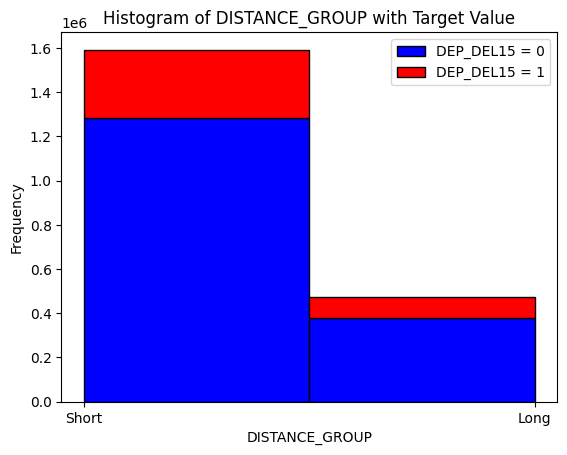

In [33]:
#zobrazime si histogram pre atribut DISTANCE_GROUP s rozdelovacim atributom DEP_DEL15
data_target_0 = joined_dataset.filter(col('DEP_DEL15') == 0).select('DISTANCE_GROUP').rdd.flatMap(lambda x: x).collect()
data_target_1 = joined_dataset.filter(col('DEP_DEL15') == 1).select('DISTANCE_GROUP').rdd.flatMap(lambda x: x).collect()

plt.hist([data_target_0, data_target_1], bins=2, stacked=True, color=['blue', 'red'], edgecolor='black')
plt.title('Histogram of DISTANCE_GROUP with Target Value')
plt.xlabel('DISTANCE_GROUP')
plt.ylabel('Frequency')
plt.legend(['DEP_DEL15 = 0', 'DEP_DEL15 = 1'])
plt.show()

In [ ]:
#unikatne hodnoty pre atribut SEGMENT_NUMBER
unique_values = joined_dataset.select('SEGMENT_NUMBER').distinct()
unique_values.show()

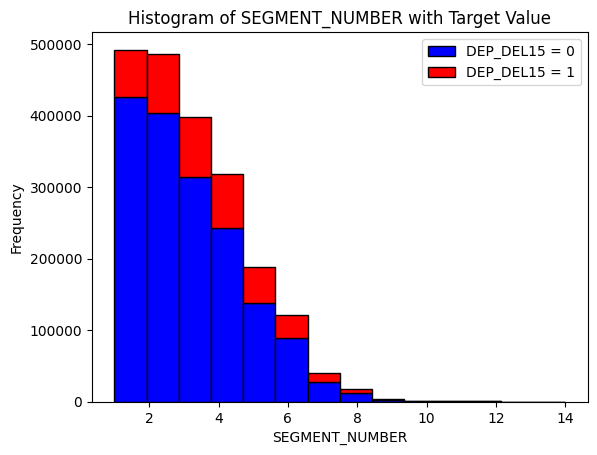

In [34]:
#histogram pre atribut segment number s rozdelovacim atributom DEP_DEL15
data_target_0 = joined_dataset.filter(col('DEP_DEL15') == 0).select('SEGMENT_NUMBER').rdd.flatMap(lambda x: x).collect()
data_target_1 = joined_dataset.filter(col('DEP_DEL15') == 1).select('SEGMENT_NUMBER').rdd.flatMap(lambda x: x).collect()

plt.hist([data_target_0, data_target_1], bins=14, stacked=True, color=['blue', 'red'], edgecolor='black')
plt.title('Histogram of SEGMENT_NUMBER with Target Value')
plt.xlabel('SEGMENT_NUMBER')
plt.ylabel('Frequency')
plt.legend(['DEP_DEL15 = 0', 'DEP_DEL15 = 1'])
plt.show()

In [35]:
#unikatne hodnoty pre atribut plane age
plane_age_counts = joined_dataset.groupBy('PLANE_AGE').count().orderBy('PLANE_AGE')

plane_age_counts.show()

+---------+------+
|PLANE_AGE| count|
+---------+------+
|      0.0| 33723|
|      1.0| 96320|
|      2.0|114840|
|      3.0|130812|
|      4.0|117722|
|      5.0|129297|
|      6.0| 75848|
|      7.0| 53096|
|      8.0| 41892|
|      9.0| 44308|
|     10.0| 52851|
|     11.0|164246|
|     12.0| 82950|
|     13.0| 86574|
|     14.0| 87432|
|     15.0| 97818|
|     16.0| 75067|
|     17.0| 91375|
|     18.0|137850|
|     19.0|100191|
+---------+------+
only showing top 20 rows



# TRANSFORMÁCIA Z NUMERICKÝCH ATRIBÚTOV NA KATEGORICKÉ

In [36]:
#vykoname binning pre atribut plane age
joined_dataset = joined_dataset.withColumn('PLANE_AGE',
                                           when(col('PLANE_AGE') < 5, 'New')
                                           .when((col('PLANE_AGE') >= 5) & (col('PLANE_AGE') < 16), 'Young')
                                           .when((col('PLANE_AGE') >= 16) & (col('PLANE_AGE') < 26), 'Middle-aged')
                                           .otherwise('Old'))

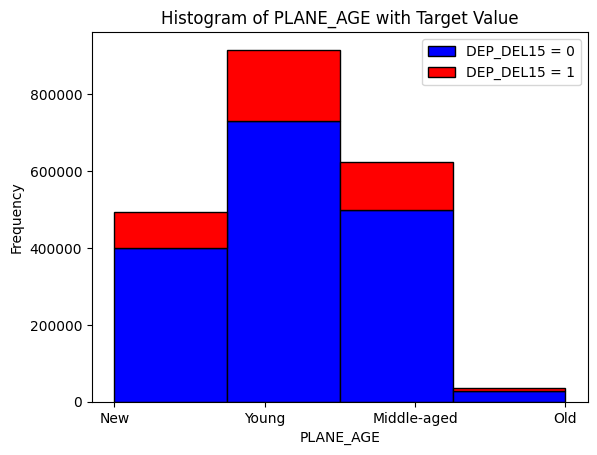

In [37]:
#histogram pre atribut plane age s rozdelovacim atributom DEP_DEL15
data_target_0 = joined_dataset.filter(col('DEP_DEL15') == 0).select('PLANE_AGE').rdd.flatMap(lambda x: x).collect()
data_target_1 = joined_dataset.filter(col('DEP_DEL15') == 1).select('PLANE_AGE').rdd.flatMap(lambda x: x).collect()

plt.hist([data_target_0, data_target_1], bins=4, stacked=True, color=['blue', 'red'], edgecolor='black')
plt.title('Histogram of PLANE_AGE with Target Value')
plt.xlabel('PLANE_AGE')
plt.ylabel('Frequency')
plt.legend(['DEP_DEL15 = 0', 'DEP_DEL15 = 1'])
plt.show()

In [38]:
# binning pre atribut number of seats - prevedieme ho na plane size a dropneme numberofseats
joined_dataset = joined_dataset.withColumn('PLANE_SIZE',
                                           when(col('NUMBER_OF_SEATS') <= 100, 'SMALL')
                                           .when((col('NUMBER_OF_SEATS') > 100) & (col('NUMBER_OF_SEATS') <= 200), 'MEDIUM')
                                           .otherwise('LARGE'))
joined_dataset = joined_dataset.drop('NUMBER_OF_SEATS')

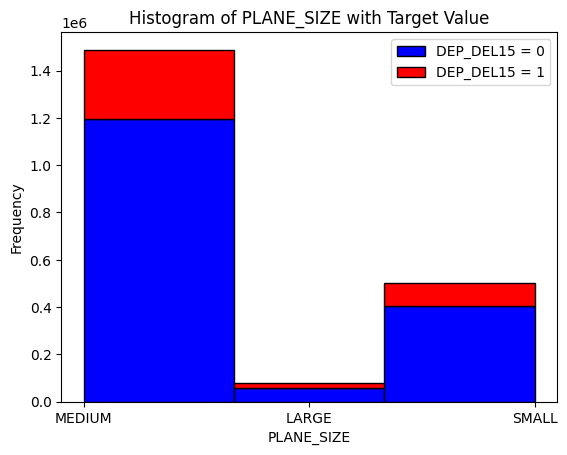

In [39]:
# histogram pre Plane size
data_target_0 = joined_dataset.filter(col('DEP_DEL15') == 0).select('PLANE_SIZE').rdd.flatMap(lambda x: x).collect()
data_target_1 = joined_dataset.filter(col('DEP_DEL15') == 1).select('PLANE_SIZE').rdd.flatMap(lambda x: x).collect()

plt.hist([data_target_0, data_target_1], bins=3, stacked=True, color=['blue', 'red'], edgecolor='black')
plt.title('Histogram of PLANE_SIZE with Target Value')
plt.xlabel('PLANE_SIZE')
plt.ylabel('Frequency')
plt.legend(['DEP_DEL15 = 0', 'DEP_DEL15 = 1'])
plt.show()

# ZÁKLADNÉ ŠTATISTIKY PRE NUMERICKÉ ATRIBÚTY

In [40]:
#zakladne informacie o kazdom numerickom atribute
column_data_types = joined_dataset.dtypes

numerical_columns = [column for column, dtype in column_data_types if dtype in ['int', 'float']]

for column in numerical_columns:
    joined_dataset.describe(column).show()

+-------+------------------+
|summary|    SEGMENT_NUMBER|
+-------+------------------+
|  count|           2067797|
|   mean|2.9429866664861204|
| stddev|1.7066717954460542|
|    min|                 1|
|    max|                14|
+-------+------------------+



+-------+------------------+
|summary|CONCURRENT_FLIGHTS|
+-------+------------------+
|  count|           2067797|
|   mean|22.493251997173804|
| stddev| 12.88884209300727|
|    min|                 1|
|    max|                66|
+-------+------------------+



+-------+---------------------+
|summary|AIRPORT_FLIGHTS_MONTH|
+-------+---------------------+
|  count|              2067797|
|   mean|   10207.306574097942|
| stddev|    4846.174055981782|
|    min|                 1105|
|    max|                19667|
+-------+---------------------+



+-------+---------------------+
|summary|AIRLINE_FLIGHTS_MONTH|
+-------+---------------------+
|  count|              2067797|
|   mean|    61387.19118849674|
| stddev|    34179.38367883243|
|    min|                 5582|
|    max|               117728|
+-------+---------------------+



+-------+-----------------------------+
|summary|AIRLINE_AIRPORT_FLIGHTS_MONTH|
+-------+-----------------------------+
|  count|                      2067797|
|   mean|           2114.7967121530787|
| stddev|            1607.764097150521|
|    min|                            1|
|    max|                         6234|
+-------+-----------------------------+



+-------+------------------------+
|summary|AVG_MONTHLY_PASS_AIRPORT|
+-------+------------------------+
|  count|                 2067797|
|   mean|      1357804.4627195029|
| stddev|       714999.1924115292|
|    min|                  105972|
|    max|                 2780593|
+-------+------------------------+



+-------+------------------------+
|summary|AVG_MONTHLY_PASS_AIRLINE|
+-------+------------------------+
|  count|                 2067797|
|   mean|       7742474.528022335|
| stddev|        4901027.35546546|
|    min|                  473794|
|    max|                13382999|
+-------+------------------------+



+-------+-----------------------+
|summary|FLT_ATTENDANTS_PER_PASS|
+-------+-----------------------+
|  count|                2067797|
|   mean|   1.002748937222938...|
| stddev|    8.72649038815402E-5|
|    min|                    0.0|
|    max|           3.4840766E-4|
+-------+-----------------------+



+-------+--------------------+
|summary|GROUND_SERV_PER_PASS|
+-------+--------------------+
|  count|             2067797|
|   mean|1.425178883263404...|
| stddev|5.153126966878823...|
|    min|         7.134695E-6|
|    max|        2.2898547E-4|
+-------+--------------------+



+-------+------------------+
|summary|          LATITUDE|
+-------+------------------+
|  count|           2067797|
|   mean|35.422613559181684|
| stddev|5.3652914584670315|
|    min|            21.319|
|    max|             47.62|
+-------+------------------+



+-------+------------------+
|summary|         LONGITUDE|
+-------+------------------+
|  count|           2067797|
|   mean| -97.3901030650353|
| stddev|20.008050767221498|
|    min|          -157.922|
|    max|           -73.805|
+-------+------------------+



+-------+------------------+
|summary|         mean_TAVG|
+-------+------------------+
|  count|           2067797|
|   mean| 63.58433522395056|
| stddev|14.931458926903046|
|    min|             21.75|
|    max|              96.0|
+-------+------------------+



+-------+------------------+
|summary|         mean_SNWD|
+-------+------------------+
|  count|           2067797|
|   mean|0.1184257181657991|
| stddev|0.3297344627948895|
|    min|               0.0|
|    max|              3.78|
+-------+------------------+



+-------+-----------------+
|summary|        mean_AWND|
+-------+-----------------+
|  count|          2067797|
|   mean|8.293304673235781|
| stddev|2.271047780324123|
|    min|           2.6275|
|    max|           17.615|
+-------+-----------------+



+-------+------------------+
|summary|         mean_TMAX|
+-------+------------------+
|  count|           2067797|
|   mean| 72.91238625593164|
| stddev|15.807541146608045|
|    min|              26.8|
|    max|            108.25|
+-------+------------------+



+-------+------------------+
|summary|         mean_TMIN|
+-------+------------------+
|  count|           2067797|
|   mean| 55.12788008810622|
| stddev|14.809936558465226|
|    min|              14.5|
|    max|              84.4|
+-------+------------------+



+-------+------------------+
|summary|         mean_WDF2|
+-------+------------------+
|  count|           2067797|
|   mean|203.88946230811092|
| stddev|60.208216680057966|
|    min|              35.0|
|    max|             342.5|
+-------+------------------+



+-------+------------------+
|summary|         mean_WDF5|
+-------+------------------+
|  count|           2067797|
|   mean|203.88540006182447|
| stddev| 60.24006856389594|
|    min|              42.5|
|    max|             350.0|
+-------+------------------+



+-------+------------------+
|summary|         mean_WSF5|
+-------+------------------+
|  count|           2067797|
|   mean|25.009051758196943|
| stddev| 4.640427214304968|
|    min|            10.825|
|    max|              46.8|
+-------+------------------+



+-------+------------------+
|summary|         mean_WSF2|
+-------+------------------+
|  count|           2067797|
|   mean|19.277724494709346|
| stddev| 3.615060720055884|
|    min|             9.425|
|    max|            35.775|
+-------+------------------+



+-------+-------------------+
|summary|          mean_SNOW|
+-------+-------------------+
|  count|            2067797|
|   mean|0.02126037750644542|
| stddev| 0.1155600725352196|
|    min|                0.0|
|    max|              2.175|
+-------+-------------------+



+-------+-------------------+
|summary|          mean_PRCP|
+-------+-------------------+
|  count|            2067797|
|   mean|0.10223433218577824|
| stddev|0.16834283201945388|
|    min|                0.0|
|    max|              2.315|
+-------+-------------------+



+-------+-------------------+
|summary|          mean_WT01|
+-------+-------------------+
|  count|            2067797|
|   mean|0.32875438099551835|
| stddev| 0.2627474899589411|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



+-------+-------------------+
|summary|          mean_WT02|
+-------+-------------------+
|  count|            2067797|
|   mean|0.03196039084990115|
| stddev|0.09014421515394043|
|    min|                0.0|
|    max|               0.75|
+-------+-------------------+



+-------+-------------------+
|summary|          mean_WT03|
+-------+-------------------+
|  count|            2067797|
|   mean|0.11519897832922245|
| stddev|0.19984751772307632|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



+-------+--------------------+
|summary|           mean_WT04|
+-------+--------------------+
|  count|             2067797|
|   mean|0.005336669932798075|
| stddev|0.035800685660511145|
|    min|                 0.0|
|    max|                 0.5|
+-------+--------------------+



+-------+--------------------+
|summary|           mean_WT05|
+-------+--------------------+
|  count|             2067797|
|   mean|0.002333763917737...|
| stddev|0.023499434169223114|
|    min|                 0.0|
|    max|                 0.5|
+-------+--------------------+



+-------+--------------------+
|summary|           mean_WT06|
+-------+--------------------+
|  count|             2067797|
|   mean|0.005114887994355791|
| stddev|0.040137959087038426|
|    min|                 0.0|
|    max|                0.75|
+-------+--------------------+



+-------+--------------------+
|summary|           mean_WT07|
+-------+--------------------+
|  count|             2067797|
|   mean|3.715790301940392...|
| stddev| 0.00978471180223809|
|    min|                 0.0|
|    max|                 0.5|
+-------+--------------------+



+-------+-------------------+
|summary|          mean_WT08|
+-------+-------------------+
|  count|            2067797|
|   mean|0.14452097352461232|
| stddev|0.20937174735292086|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+



+-------+--------------------+
|summary|           mean_WT09|
+-------+--------------------+
|  count|             2067797|
|   mean|0.002136597558718...|
| stddev| 0.02397164611112354|
|    min|                 0.0|
|    max|                 0.5|
+-------+--------------------+



+-------+---------+
|summary|mean_WT10|
+-------+---------+
|  count|  2067797|
|   mean|      0.0|
| stddev|      0.0|
|    min|      0.0|
|    max|      0.0|
+-------+---------+



+-------+---------+
|summary|mean_WT11|
+-------+---------+
|  count|  2067797|
|   mean|      0.0|
| stddev|      0.0|
|    min|      0.0|
|    max|      0.0|
+-------+---------+



In [41]:
#rozdelenie target atributu
rows_count = joined_dataset.groupBy('DEP_DEL15').count()
rows_count.show()

+---------+-------+
|DEP_DEL15|  count|
+---------+-------+
|     true| 408262|
|    false|1659535|
+---------+-------+



# HISTOGRAMY

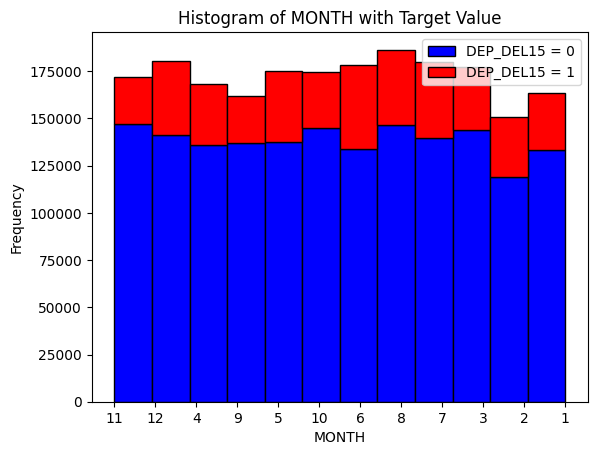

In [42]:
#histogram pre atribut MONTH
data_target_0 = joined_dataset.filter(col('DEP_DEL15') == 0).select('MONTH').rdd.flatMap(lambda x: x).collect()
data_target_1 = joined_dataset.filter(col('DEP_DEL15') == 1).select('MONTH').rdd.flatMap(lambda x: x).collect()

plt.hist([data_target_0, data_target_1], bins=12, stacked=True, color=['blue', 'red'], edgecolor='black')
plt.title('Histogram of MONTH with Target Value')
plt.xlabel('MONTH')
plt.ylabel('Frequency')
plt.legend(['DEP_DEL15 = 0', 'DEP_DEL15 = 1'])
plt.show()

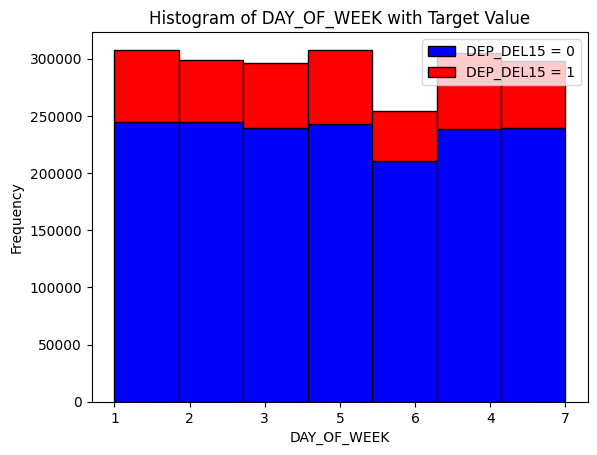

In [43]:
#histogram pre atribut DAY_OF_WEEK
data_target_0 = joined_dataset.filter(col('DEP_DEL15') == 0).select('DAY_OF_WEEK').rdd.flatMap(lambda x: x).collect()
data_target_1 = joined_dataset.filter(col('DEP_DEL15') == 1).select('DAY_OF_WEEK').rdd.flatMap(lambda x: x).collect()

plt.hist([data_target_0, data_target_1], bins=7, stacked=True, color=['blue', 'red'], edgecolor='black')
plt.title('Histogram of DAY_OF_WEEK with Target Value')
plt.xlabel('DAY_OF_WEEK')
plt.ylabel('Frequency')
plt.legend(['DEP_DEL15 = 0', 'DEP_DEL15 = 1'])
plt.show()

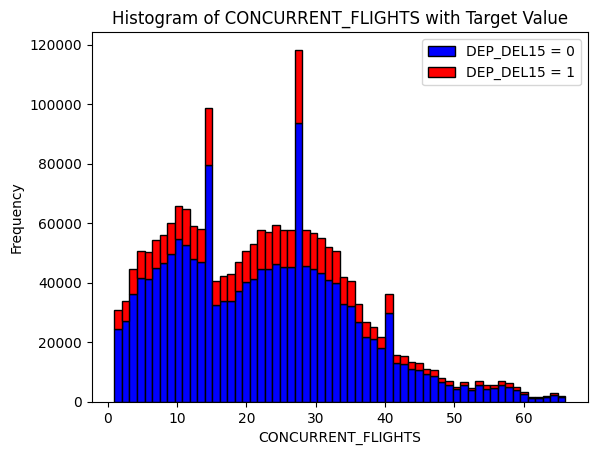

In [44]:
#histogram pre atribut COnCURRENT_FLIGHTS
data_target_0 = joined_dataset.filter(col('DEP_DEL15') == 0).select('CONCURRENT_FLIGHTS').rdd.flatMap(lambda x: x).collect()
data_target_1 = joined_dataset.filter(col('DEP_DEL15') == 1).select('CONCURRENT_FLIGHTS').rdd.flatMap(lambda x: x).collect()

plt.hist([data_target_0, data_target_1], bins=60, stacked=True, color=['blue', 'red'], edgecolor='black')
plt.title('Histogram of CONCURRENT_FLIGHTS with Target Value')
plt.xlabel('CONCURRENT_FLIGHTS')
plt.ylabel('Frequency')
plt.legend(['DEP_DEL15 = 0', 'DEP_DEL15 = 1'])
plt.show()

# SAMPLING

In [46]:
#vytvorenie 10%vzorky z povodneho datasetu na modelovacie ucely
joined_dataset = joined_dataset.withColumn('DEP_DEL15', col('DEP_DEL15').cast('int'))

unique_values = joined_dataset.select('DEP_DEL15').distinct().rdd.flatMap(lambda x: x).collect()

fractions = {value: 0.1 for value in unique_values}

sampled_data = joined_dataset.sampleBy('DEP_DEL15', fractions)

sampled_data.groupBy('DEP_DEL15').count().show()

+---------+------+
|DEP_DEL15| count|
+---------+------+
|        1| 40486|
|        0|165616|
+---------+------+



In [48]:
#rozlozenie mesiacov v datasete
month_counts = sampled_data.groupBy('MONTH').count()
month_counts.show()

+-----+-----+
|MONTH|count|
+-----+-----+
|    7|18099|
|   11|17062|
|    3|17754|
|    8|18773|
|    5|17333|
|    6|17623|
|    9|16078|
|    1|16301|
|   10|17381|
|    4|16701|
|   12|17764|
|    2|15233|
+-----+-----+



In [49]:
#rozlozenie dni v datasete
days_counts = sampled_data.groupBy('DAY_OF_WEEK').count()
days_counts.show()

+-----------+-----+
|DAY_OF_WEEK|count|
+-----------+-----+
|          7|29553|
|          3|29575|
|          5|30546|
|          6|25237|
|          1|30826|
|          4|30578|
|          2|29787|
+-----------+-----+



In [51]:
#one hot encoding kategorickych atriburov
columns_to_encode = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'CARRIER_NAME', 'PLANE_AGE', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'STATION', 'PLANE_SIZE']

for column in columns_to_encode:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_index")

    sampled_data = indexer.fit(sampled_data).transform(sampled_data)

    encoder = OneHotEncoder(inputCols=[column + "_index"], outputCols=[column + "_vec"])

    model = encoder.fit(sampled_data)

    sampled_data = model.transform(sampled_data)

In [52]:
#dropneme uz nepotrebne stplce, ktore sme uz zakodovli
columns_to_drop = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'CARRIER_NAME', 'PLANE_AGE', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'STATION', 'PLANE_SIZE', 'MONTH_index', 'DAY_OF_WEEK_index', 'DEP_TIME_BLK_index', 'DISTANCE_GROUP_index', 'CARRIER_NAME_index', 'PLANE_AGE_index', 'DEPARTING_AIRPORT_index', 'PREVIOUS_AIRPORT_index', 'STATION_index', 'PLANE_SIZE_index']

for column in columns_to_drop:
    sampled_data = sampled_data.drop(column)

In [53]:
sampled_data.take(5)


[Row(DEP_DEL15=0, SEGMENT_NUMBER=3, CONCURRENT_FLIGHTS=30, AIRPORT_FLIGHTS_MONTH=17615, AIRLINE_FLIGHTS_MONTH=21620, AIRLINE_AIRPORT_FLIGHTS_MONTH=1655, AVG_MONTHLY_PASS_AIRPORT=2780593, AVG_MONTHLY_PASS_AIRLINE=2884187, FLT_ATTENDANTS_PER_PASS=3.23314598063007e-05, GROUND_SERV_PER_PASS=0.00017460144590586424, LATITUDE=33.94200134277344, LONGITUDE=-118.40799713134766, mean_TAVG=73.25, mean_SNWD=0.0014358499320223927, mean_AWND=7.769999980926514, mean_TMAX=80.25, mean_TMIN=65.75, mean_WDF2=257.5, mean_WDF5=265.0, mean_WSF5=22.75, mean_WSF2=18.575000762939453, mean_SNOW=0.0, mean_PRCP=0.0, mean_WT01=0.0, mean_WT02=0.0, mean_WT03=0.0, mean_WT04=0.0, mean_WT05=0.0, mean_WT06=0.0, mean_WT07=0.0, mean_WT08=0.0, mean_WT09=0.0, mean_WT10=0.0, mean_WT11=0.0, MONTH_vec=SparseVector(11, {10: 1.0}), DAY_OF_WEEK_vec=SparseVector(6, {}), DEP_TIME_BLK_vec=SparseVector(18, {11: 1.0}), DISTANCE_GROUP_vec=SparseVector(1, {0: 1.0}), CARRIER_NAME_vec=SparseVector(16, {6: 1.0}), PLANE_AGE_vec=SparseVector(

In [54]:
#zvektorizujeme vstupne atributy okrem targetu
columns = sampled_data.columns
columns.remove('DEP_DEL15')
print(columns)
vecAssembler = VectorAssembler(inputCols=columns, outputCol="features")
vector_data = vecAssembler.transform(sampled_data)

['SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS', 'LATITUDE', 'LONGITUDE', 'mean_TAVG', 'mean_SNWD', 'mean_AWND', 'mean_TMAX', 'mean_TMIN', 'mean_WDF2', 'mean_WDF5', 'mean_WSF5', 'mean_WSF2', 'mean_SNOW', 'mean_PRCP', 'mean_WT01', 'mean_WT02', 'mean_WT03', 'mean_WT04', 'mean_WT05', 'mean_WT06', 'mean_WT07', 'mean_WT08', 'mean_WT09', 'mean_WT10', 'mean_WT11', 'MONTH_vec', 'DAY_OF_WEEK_vec', 'DEP_TIME_BLK_vec', 'DISTANCE_GROUP_vec', 'CARRIER_NAME_vec', 'PLANE_AGE_vec', 'DEPARTING_AIRPORT_vec', 'PREVIOUS_AIRPORT_vec', 'STATION_vec', 'PLANE_SIZE_vec']


# Rozdelenie datasetu na trénovaciu a testovaciu množinu

In [55]:
#train test split
train_data, test_data = vector_data.randomSplit([0.6, 0.4],seed=1234)

print("Train data count:", train_data.count())
print("Test data count:", test_data.count())

Train data count: 123612


Test data count: 82490


In [ ]:
#distribucia target atributu v train a test sete
train_distribution = train_data.groupBy('DEP_DEL15').count()
print("Training data distribution:")
train_distribution.show()

test_distribution = test_data.groupBy('DEP_DEL15').count()
print("Testing data distribution:")
test_distribution.show()

In [56]:
#undersampling majoritnej triedy v trenovacej sade
majority_class_fraction = 0.4
fractions = {0: majority_class_fraction, 1: 1}

undersampled_data = train_data.sampleBy("DEP_DEL15", fractions)

undersampled_data.groupBy('DEP_DEL15').count().show()

+---------+-----+
|DEP_DEL15|count|
+---------+-----+
|        1|24253|
|        0|39847|
+---------+-----+



# MODELOVANIE
### Decision Tree Model
#### Natrénovanie klasifikačného modelu na trénovacej množine a jeho evaluáciu na testovacej množine.

In [58]:
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel

tree_classifier = DecisionTreeClassifier(
        featuresCol="features",                 # dátový stĺpec obsahujúci vektor vstupných atribútov
        labelCol="DEP_DEL15",           # dátový stĺpec obsahujúci cieľový atribút (indexy tried)
        impurity="entropy",                     # pre výber atribútov pri delení sa použije kritérium informačného zisku
        maxDepth=20)                             # ohraničíme maximálnu hĺbku generovaného stromu

# klasifikačný model vytvoríme volaním funkcie ‘fit’ na trénovacích dátach
tree_model = tree_classifier.fit(undersampled_data)

24/04/30 21:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
24/04/30 21:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1271.2 KiB
24/04/30 21:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1442.6 KiB
24/04/30 21:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1625.1 KiB
24/04/30 21:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1817.7 KiB
24/04/30 21:18:06 WARN DAGScheduler: Broadcasting large task binary with size 2018.1 KiB


In [59]:
# presnosť klasifikácie vyhodnotíme na testovacích dátach pomocou funkcie ‘transform’
# po klasifikácii sa do dátového rámca pridajú nové stĺpce, ktoré obsahujú predikovanú triedu a pravdepodobnosti
predictions = tree_model.transform(test_data)
# predikovaná trieda je uložená v stĺpci ‘prediction’, spočítame počet chybne klasifikovaných príkladov
# pri ktorých sa ‘prediction’ nerovná cieľovému atribútu ‘attack_type_index’
test_error = predictions.filter(predictions["prediction"] != predictions["DEP_DEL15"]).count() / float(test_data.count())
print("Testing error: {0:.4f}".format(test_error))

24/04/30 21:18:08 WARN DAGScheduler: Broadcasting large task binary with size 1491.6 KiB


Testing error: 0.3272


### Vyhodnotenie modelu použitím kontigenčnej tabuľky a vypočítaním metrík presnosti, návratnosti, F1 a MCC (Matthews Correlation Coefficient)

In [60]:
#vypocitanie confusion matrix
condition_tp = (col("DEP_DEL15") == 1) & (col("prediction") == 1)
condition_fp = (col("DEP_DEL15") == 0) & (col("prediction") == 1)
condition_tn = (col("DEP_DEL15") == 0) & (col("prediction") == 0)
condition_fn = (col("DEP_DEL15") == 1) & (col("prediction") == 0)

predictions = predictions.withColumn("TP", when(condition_tp, 1).otherwise(0))
predictions = predictions.withColumn("FP", when(condition_fp, 1).otherwise(0))
predictions = predictions.withColumn("TN", when(condition_tn, 1).otherwise(0))
predictions = predictions.withColumn("FN", when(condition_fn, 1).otherwise(0))

TP_count = predictions.filter(col("TP") == 1).count()
FP_count = predictions.filter(col("FP") == 1).count()
TN_count = predictions.filter(col("TN") == 1).count()
FN_count = predictions.filter(col("FN") == 1).count()

print("True Positives:", TP_count)
print("False Positives:", FP_count)
print("True Negatives:", TN_count)
print("False Negatives:", FN_count)

24/04/30 21:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1491.5 KiB
24/04/30 21:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1491.5 KiB
24/04/30 21:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1491.5 KiB
24/04/30 21:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1491.5 KiB


True Positives: 6336
False Positives: 17095
True Negatives: 49162
False Negatives: 9897


In [61]:
#vypocitanie metrik
precision = TP_count / (TP_count + FP_count)
print("Precision:", precision)

recall = TP_count / (TP_count + FN_count)
print("Recall:", recall)

F1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", F1_score)

accuracy = (TP_count + TN_count) / (TP_count + FP_count + TN_count + FN_count)
print("Accuracy:", accuracy)
from math import sqrt

# Matthews Correlation Coefficient (MCC)
MCC = (TP_count * TN_count - FP_count * FN_count) / sqrt((TP_count + FP_count) * (TP_count + FN_count) * (TN_count + FP_count) * (TN_count + FN_count))

print("Matthews Correlation Coefficient:", MCC)

Precision: 0.2704109939823311
Recall: 0.39031602291628165
F1 Score: 0.3194836627672448
Accuracy: 0.6727845799490847
Matthews Correlation Coefficient: 0.11664197899562236


### Linear SVM Model
#### Natrénovanie klasifikačného modelu na trénovacej množine a jeho evaluáciu na testovacej množine.

In [62]:
from pyspark.ml.classification import LinearSVC

svm_classifier = LinearSVC(featuresCol="features", labelCol="DEP_DEL15")

svm_model = svm_classifier.fit(undersampled_data)

24/04/30 21:21:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [63]:
predictions = svm_model.transform(test_data)
test_error = predictions.filter(predictions["prediction"] != predictions["DEP_DEL15"]).count() / float(test_data.count())
print("Testing error: {0:.4f}".format(test_error))

Testing error: 0.2385


### Vyhodnotenie modelu použitím kontigenčnej tabuľky a vypočítaním metrík presnosti, návratnosti, F1 a MCC (Matthews Correlation Coefficient)

In [64]:
#vypocitanie confusion matrix
condition_tp = (col("DEP_DEL15") == 1) & (col("prediction") == 1)
condition_fp = (col("DEP_DEL15") == 0) & (col("prediction") == 1)
condition_tn = (col("DEP_DEL15") == 0) & (col("prediction") == 0)
condition_fn = (col("DEP_DEL15") == 1) & (col("prediction") == 0)

predictions = predictions.withColumn("TP", when(condition_tp, 1).otherwise(0))
predictions = predictions.withColumn("FP", when(condition_fp, 1).otherwise(0))
predictions = predictions.withColumn("TN", when(condition_tn, 1).otherwise(0))
predictions = predictions.withColumn("FN", when(condition_fn, 1).otherwise(0))

TP_count = predictions.filter(col("TP") == 1).count()
FP_count = predictions.filter(col("FP") == 1).count()
TN_count = predictions.filter(col("TN") == 1).count()
FN_count = predictions.filter(col("FN") == 1).count()

print("True Positives:", TP_count)
print("False Positives:", FP_count)
print("True Negatives:", TN_count)
print("False Negatives:", FN_count)

True Positives: 2547
False Positives: 5988
True Negatives: 60269
False Negatives: 13686


In [65]:
#vypocitanie metrik
precision = TP_count / (TP_count + FP_count)
print("Precision:", precision)

recall = TP_count / (TP_count + FN_count)
print("Recall:", recall)

F1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", F1_score)

accuracy = (TP_count + TN_count) / (TP_count + FP_count + TN_count + FN_count)
print("Accuracy:", accuracy)
from math import sqrt

# Matthews Correlation Coefficient (MCC)
MCC = (TP_count * TN_count - FP_count * FN_count) / sqrt((TP_count + FP_count) * (TP_count + FN_count) * (TN_count + FP_count) * (TN_count + FN_count))

print("Matthews Correlation Coefficient:", MCC)

Precision: 0.2984182776801406
Recall: 0.1569026058029939
F1 Score: 0.2056686046511628
Accuracy: 0.7614983634379925
Matthews Correlation Coefficient: 0.08684189895044557


### Random Forests Model
#### Natrénovanie klasifikačného modelu na trénovacej množine a jeho evaluáciu na testovacej množine.

In [70]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="DEP_DEL15", numTrees=10, maxDepth=20)

rf_model = rf_classifier.fit(undersampled_data)

24/04/30 21:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
24/04/30 21:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1309.1 KiB
24/04/30 21:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1678.1 KiB
24/04/30 21:27:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/04/30 21:27:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/04/30 21:27:18 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/04/30 21:27:21 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/04/30 21:27:23 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/04/30 21:27:25 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
24/04/30 21:27:28 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
24/04/30 21:27:31 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
24/04/30 21:27:34 WARN DAGScheduler: Broadcas

In [71]:
predictions = rf_model.transform(test_data)
# predikovaná trieda je uložená v stĺpci ‘prediction’, spočítame počet chybne klasifikovaných príkladov
# pri ktorých sa ‘prediction’ nerovná cieľovému atribútu ‘attack_type_index’
test_error = predictions.filter(predictions["prediction"] != predictions["DEP_DEL15"]).count() / float(test_data.count())
print("Testing error: {0:.4f}".format(test_error))

24/04/30 21:27:39 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


Testing error: 0.2453


### Vyhodnotenie modelu použitím kontigenčnej tabuľky a vypočítaním metrík presnosti, návratnosti, F1 a MCC (Matthews Correlation Coefficient)

In [72]:
#vypocitanie confusion matrix
condition_tp = (col("DEP_DEL15") == 1) & (col("prediction") == 1)
condition_fp = (col("DEP_DEL15") == 0) & (col("prediction") == 1)
condition_tn = (col("DEP_DEL15") == 0) & (col("prediction") == 0)
condition_fn = (col("DEP_DEL15") == 1) & (col("prediction") == 0)

predictions = predictions.withColumn("TP", when(condition_tp, 1).otherwise(0))
predictions = predictions.withColumn("FP", when(condition_fp, 1).otherwise(0))
predictions = predictions.withColumn("TN", when(condition_tn, 1).otherwise(0))
predictions = predictions.withColumn("FN", when(condition_fn, 1).otherwise(0))

TP_count = predictions.filter(col("TP") == 1).count()
FP_count = predictions.filter(col("FP") == 1).count()
TN_count = predictions.filter(col("TN") == 1).count()
FN_count = predictions.filter(col("FN") == 1).count()

print("True Positives:", TP_count)
print("False Positives:", FP_count)
print("True Negatives:", TN_count)
print("False Negatives:", FN_count)

24/04/30 21:27:52 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/04/30 21:27:59 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/04/30 21:28:04 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/04/30 21:28:11 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


True Positives: 4389
False Positives: 8393
True Negatives: 57864
False Negatives: 11844


In [73]:
#vypocitanie metrik
precision = TP_count / (TP_count + FP_count)
print("Precision:", precision)

recall = TP_count / (TP_count + FN_count)
print("Recall:", recall)

F1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", F1_score)

accuracy = (TP_count + TN_count) / (TP_count + FP_count + TN_count + FN_count)
print("Accuracy:", accuracy)
from math import sqrt

# Matthews Correlation Coefficient (MCC)
MCC = (TP_count * TN_count - FP_count * FN_count) / sqrt((TP_count + FP_count) * (TP_count + FN_count) * (TN_count + FP_count) * (TN_count + FN_count))

print("Matthews Correlation Coefficient:", MCC)

Precision: 0.3433734939759036
Recall: 0.2703751617076326
F1 Score: 0.3025331724969843
Accuracy: 0.7546732937325736
Matthews Correlation Coefficient: 0.15788345745242213
